# 

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import gc
import timeit

#gc.collect()
#plt.style.use('ggplot')
plt.style.use('fivethirtyeight')
#plt.style.use('default')

import seaborn as sns

from scipy.special import kl_div, rel_entr
from scipy.stats import entropy


%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
import crossdev_dim as crd
import divariance as dvr

In [2]:

def generate_distributions(mean1, mean2, var1, var2, corr, size=1000):
    """
    Generate two distributions with specified means, variances, and covariance.

    Parameters:
        mean1 (float): Mean of the first distribution.
        mean2 (float): Mean of the second distribution.
        var1 (float): Variance of the first distribution.
        var2 (float): Variance of the second distribution.
        #cov (float): Covariance between the two distributions.
        corr (float): correlation between the two distributions
        size (int): Number of samples to generate.

    Returns:
        x (np.ndarray): Samples from the first distribution.
        y (np.ndarray): Samples from the second distribution.
    """
    # calculate covar
    cov = corr*np.sqrt(var1)*np.sqrt(var2)
    
    # Create the covariance matrix
    cov_matrix = np.array([[var1, cov],
                           [cov, var2]])
    # Mean vector
    mean_vector = np.array([mean1, mean2])
    # Generate samples
    samples = np.random.multivariate_normal(mean_vector, cov_matrix, size)
    x, y = samples[:, 0], samples[:, 1]
    return x, y

# Example usage:
x, y = generate_distributions(mean1=0, mean2=0, var1=1, var2=2, corr=1, size=1000)


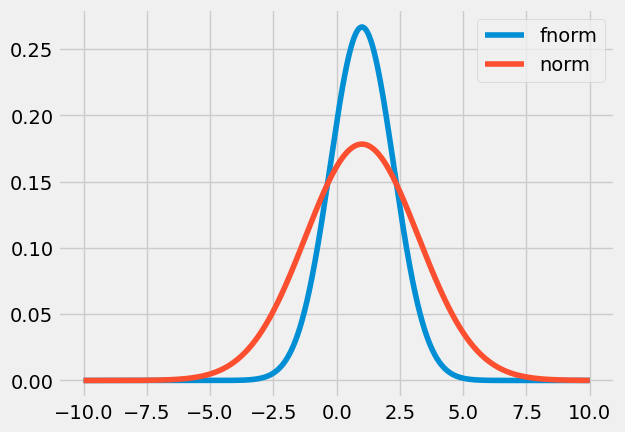

In [3]:
def fnorm(x,mean,var):
    scale = 1/np.sqrt(2*np.pi*np.sqrt(var))
    num = -1*np.power(np.power(x-mean,2),1)
    den = np.sqrt(2*var)
    return scale*np.exp(num/den)

def anorm(x,mean,var):
    scale = 1/np.sqrt(2*np.pi*var)
    num = -1*np.power(np.power(x-mean,2),1)
    den = 2*var
    return scale*np.exp(num/den)

min_val, max_val,bins = -10,10,1000
xrange = np.linspace(min_val, max_val,bins)
mean = 1
var = 5
alt_x = [fnorm(n,mean,var) for n in xrange]
act_x = [anorm(n,mean,var) for n in xrange]
plt.plot(xrange,alt_x,label='fnorm')
plt.plot(xrange,act_x,label='norm')
plt.legend()

In [55]:
#plt.plot(np.log(np.array(alt_x)/np.array(act_x)))
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [4]:
x, y = generate_distributions(mean1=0, mean2=1, var1=1, var2=2, corr=1, size=1000)

print(crd.cross_variance(x,y,'ratio'))
print(1-np.sqrt(dvr.dirrelation(x,y)))
print(1/np.sqrt(dvr.dirrelation(x,y)))

1.1906549056856206
0.1605526632441867
1.191259959040039


0.0
25.075213495529862
inf


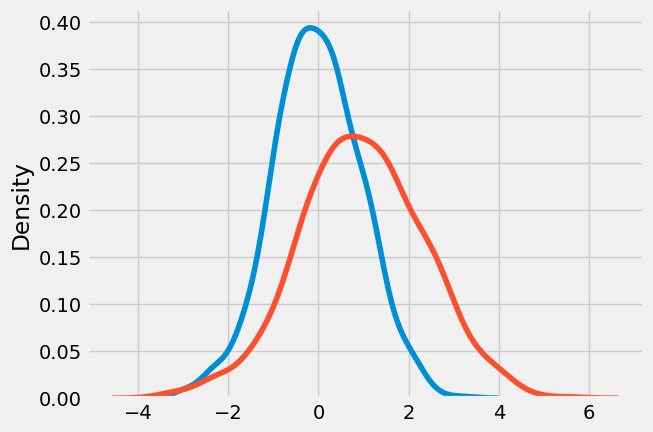

In [5]:

ax,bx = sns.kdeplot(x).get_lines()[0].get_data()
ay,by = sns.kdeplot(y).get_lines()[0].get_data()
print(sum(rel_entr(bx/np.sum(bx),by/np.sum(by))))
print(np.sum(bx))
print(entropy(x,qk=y))

In [50]:
class Empirical:
    """Calculating divariance based and other divergence statistics from arrays/samples of two distributions.
    If passing statistics (mean,variance) to formula, use the Divariance.Formulas sister class
    
    Divariance is the combined variance of two distributions if the variance of each observations is calculated
    relative to the membership of the other distributions, rather than the mean.  The squared differences of each (n) observerations
    in X vs each (m) observations in Y are accumulated into a rectangular matrix via double summation over all (n) and (m).
    
    divariance(var-sigma) = [Summation_x=i^n Summation_y=j^m (x_i - y_j)**2) ]/(2mn)

    This can be simplified to a function of moments:

    divariance = [(mean1-mean2)**2 + var1 + var2]/2
    
    Most metric methods take parameters:
    -------------------------------------
    arr_a: numpy array
    arr_b: numpy array

    Methods
    -------
    divariance(mean1,mean2,var1, var2)
        returns divariance, a metric of divergence between two distributions scaled the same as variance
    dirrelation(mean1,mean2,var1, var2)
        returns dirrelation, divariance scaled by the product of sigma1*sigma2, similarly to correlation
    frechet_distance_norms(mean1,mean2,var1, var2)
        returns frechet distance applied to normal-like distributions
    frechet_divergence(mean1,mean2,var1, var2)
        returns frechet_distance_norms scaled by the product of sigmas
    RDD(mean1,mean2,var1, var2):
        returns root dirrelation divergence, a metric similar to frechet_divergence but with dampened gradients
    divergence_dampening(x,y=2)

    kl_divergence(cls,x,y,bins=100,calculator='scipi'):
        returns KL Divergence of two 1-d arrays of raw values (not distributions)
    """
    def __init__(self):
        #attributes
        pass
    #methods
    @staticmethod
    def divariance(arr_a, arr_b):
        """dvr: divariance    variance of swapped members of two distributions
        I subtract one from denomanator to match covariance... only meaninful for small sample sizes"""
        a_mean, b_mean = arr_a.sum(axis=-1)/(arr_a.shape[-1]-1), arr_b.sum(axis=-1)/(arr_b.shape[-1]-1)#arr_a.mean(axis=-1), arr_b.mean(axis=-1)
        a_sqr_mean, b_sqr_mean = np.power(arr_a,2).sum(axis=-1)/(arr_a.shape[-1]-1) , np.power(arr_b,2).sum(axis=-1)/(arr_b.shape[-1]-1)#np.power(arr_a,2).mean(axis=-1) , np.power(arr_b,2).mean(axis=-1) 
        dvr = (a_sqr_mean+b_sqr_mean)/2 - a_mean*b_mean
        return dvr
    @classmethod
    def sdd(cls,arr_a,arr_b):
    """sdd: standard dideviation - root divariance, compare to standard deviation """
    return np.sqrt(cls.divariance(arr_a, arr_b))
    @classmethod
    def dirrelation(cls,arr_a,arr_b):
        """dirrelation: sigma product/divariance     
        compare to correlation, but measures deviation of magnitude vs direction.
        sigma product is the pearson denominator (sigma_a*sigma_b)
        the inverse (1/d) is truly scaled to correlation, but is scaled [1,inf]"""
        return cls.divariance(arr_a, arr_b)/(arr_a.std(axis=-1)*arr_b.std(axis=-1)) 

    
    @staticmethod
    def _dist_from_range(arr,drange):
        '''returns a probability density distribution from a sample array of values and an array of bins
        parameters
        ----------
        arr: numpy array
            target distribution that the probability density distribution will be based on 
        drange: numpy array
            np.linspace or np.arange deliniating the bins
        '''
        return ((arr[:]>drange[:-1,np.newaxis])&(arr[:]<=drange[1:,np.newaxis])).sum(axis=1)/len(arr)
    #x,y = x_s[0],y_s[0]
    @staticmethod
    def _kl(a, b):
        '''simple implementation of KL divergence based on formula
        a: np.array (bin, probability)
            probability density distribution
        b: np.array (bin, probability)
            probability density distribution
        a and b should share the same bins
        '''
        a = np.asarray(a, dtype=float)
        b = np.asarray(b, dtype=float)
        a_mask = np.where(a>0,True,False)
        b_mask = np.where(b>0,True,False)
        return np.sum(np.where(a_mask*b_mask,a * np.log(a / b), 0))
    @classmethod
    def kl_divergence(cls,arr_a,arr_b,bins=100,calculator='scipi'):
        '''Calculated empirical KL divergence from two numpy arrays.  A probability density is calculated
        for each array based on bins determined from min and max values of the arrays.
        arr_a: 1-d numpy array
        arr_b: 1-d numpy array
        bins: int
            number of bins to divide array over (can't exceed length of shortest array)
        calculator: 'scipi' or 'code'
            determines how KL Divergence is calculated.  should be equivalent
        '''
        min_val = min(np.min(arr_a),np.min(arr_b))-0.01
        max_val = max(np.max(arr_a),np.max(arr_b))
        drange = np.linspace(min_val, max_val,bins)
        #np.sum((x>drange[:-1])&(x<=drange[1:]))
        x_pd = cls._dist_from_range(x,drange)
        y_pd = cls._dist_from_range(y,drange)
        if calculator == 'scipi':
            return np.sum(np.nan_to_num(kl_div(x_pd,y_pd),posinf=0))
        if calculator == 'code':
            return _kl(x_pd,y_pd)
    

In [52]:
Empirical.kl_divergence(x,y+0.05)

np.float64(0.05083456037099898)

In [42]:
def dist_from_range(arr,drange):
    return ((arr[:]>drange[:-1,np.newaxis])&(arr[:]<=drange[1:,np.newaxis])).sum(axis=1)/len(arr)
#x,y = x_s[0],y_s[0]

def kl_div_from_arrays(x,y,bins=100,calculator='scipi'):
    min_val = min(np.min(x),np.min(y))-0.01
    max_val = max(np.max(x),np.max(y))
    drange = np.linspace(min_val, max_val,bins)
    #np.sum((x>drange[:-1])&(x<=drange[1:]))
    x_pd = dist_from_range(x,drange)
    y_pd = dist_from_range(y,drange)
    if calculator == 'scipi':
        return np.sum(np.nan_to_num(kl_div(x_pd,y_pd),posinf=0))
    if calculator == 'code':
        
        return KL(x_pd,y_pd)
    #sum(np.nan_to_num(kl_div(y_pd,x_pd),posinf=0))


In [84]:
kl_div_from_arrays(x,y,calculator='scipi')
#np.where(x>0,1,0)
#a_mask = np.where(x>0,1,0)
##b_mask = np.where(y>0,1,0)
#np.sum(np.where(a_mask*b_mask,KL(x,y),0))


np.float64(0.393449276282631)

In [7]:
def KL(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    a_mask = np.where(a>0,True,False)
    b_mask = np.where(b>0,True,False)
    return np.sum(np.where(a_mask*b_mask,a * np.log(a / b), 0))
#KL(x_s[-1],y_s[-1])

In [8]:
def plot_scatter(x,y, ax=None,return_ax=True,show_ylabel=True):
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(x, y, alpha=0.5)
    ax.set_xlabel('Distr x')
    if show_ylabel:
        ax.set_ylabel('Distr y')
        #ax.set_title('Scatter Plot of Generated Distributions')
    if return_ax:
        return ax
    else:
        plt.show()
    
    #crd.cross_variance(x,y,c_type='ratio'),np.corrcoef(x,y)[0,1]
#_ = plot_scatter(x,y)

In [9]:
def plot_density(x,y, ax=None,return_ax=True,figsize=None,xlabel='x',ylabel='y'):
    if ax is None:
        if figsize is None:
            fig, ax = plt.subplots()
        else:
            fig, ax = plt.subplots(figsize=figsize)
    sns.set_style('whitegrid')
    sns.kdeplot(x, bw_method=0.5,label=xlabel,ax=ax)
    sns.kdeplot(y, bw_method=0.5,label=ylabel,ax=ax)
    #ax.set_title('KDE Plot of Generated Distributions')
    ax.legend();
    if return_ax:
        return ax;
    else:
        plt.show();
#_ = plot_density(x,y)

In [10]:
corr = 1
mean1=0
mean2=0
var1=1
var2=1
cov=var1*var2*corr
size=1000
x, y = generate_distributions(mean1, mean2, var1, var2, corr, size)
#crd.cross_variance(x,y,c_type='ratio'),np.corrcoef(x,y)[0,1]
dvr.divariance(x,y), dvr.dirrelation(x,y)


(np.float64(1.0135114818842803), np.float64(0.9990005012565861))

In [12]:
%%timeit
(dvr.dirrelation(x,y)-1)*2

48.5 μs ± 1.03 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [13]:
%%timeit
kl_div_from_arrays(x,y)

560 μs ± 8.13 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [14]:
%%timeit
np.corrcoef(x,y)[0,1]

53 μs ± 415 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [15]:
%%timeit
(crd.cross_variance(x,y,c_type='ratio')-1)*2

59.5 μs ± 2.45 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
class Divariance:
    def __init__(self):
        #attributes
        
        #methods

        #Classes
        class Moments:
            def __init__(self):
                #attributes

                #methods
                                

In [53]:

class Formulas:
    """Calculating divariance based divergence statistics from 1st and 2nd moments of two distributions.
    If passing arrays, use the Divariance.Arrays sister class
    
    Divariance is the combined variance of two distributions if the variance of each observations is calculated
    relative to the membership of the other distributions, rather than the mean.  The squared differences of each (n) observerations
    in X vs each (m) observations in Y are accumulated into a rectangular matrix via double summation over all (n) and (m).
    
    divariance(var-sigma) = [Summation_x=i^n Summation_y=j^m (x_i - y_j)**2) ]/(2mn)

    This can be simplified to a function of moments:

    divariance = [(mean1-mean2)**2 + var1 + var2]/2
    
    Most metric methods takes parameters:
    -------------------------------------
    mean1: float
        mean of first distribution
    mean2: float
        mean of second distribuition
    var1: float
        variance of first distribution
    var2: float
        variance of second distribuition

    Methods
    -------
    divariance(mean1,mean2,var1, var2)
        returns divariance, a metric of divergence between two distributions scaled the same as variance
    dirrelation(mean1,mean2,var1, var2)
        returns dirrelation, divariance scaled by the product of sigma1*sigma2, similarly to correlation
    frechet_distance_norms(mean1,mean2,var1, var2)
        returns frechet distance applied to normal-like distributions
    frechet_divergence(mean1,mean2,var1, var2)
        returns frechet_distance_norms scaled by the product of sigmas
    RDD(mean1,mean2,var1, var2):
        returns root dirrelation divergence, a metric similar to frechet_divergence but with dampened gradients
    divergence_dampening(x,y=2)
    """
    def __init__(self):
        #attributes
        pass
    #methods
    @staticmethod
    def divariance(self,mean1,mean2,var1, var2,**_):
        '''returns divariance, a metric of divergence between two distributions scaled the same as variance'''
        return (np.power(mean1-mean2,2)+var1+var2)/2
    
    @classmethod
    def dirrelation(cls,mean1,mean2,var1, var2,**_):
        '''returns dirrelation, divariance scaled by the product of sigma1*sigma2, similarly to correlation'''
        return cls.divariance/(np.sqrt(var1*var2))
    
    @staticmethod
    def frechet_distance_norms(self,mean1,mean2,var1, var2,**_):
        '''returns frechet distance applied to normal-like distributions'''
        return (np.power(mean1-mean2,2)+np.power(var1-var2,2))

    @classmethod
    def frechet_divergence(cls,mean1,mean2,var1, var2,**_):
        '''returns frechet_distance_norms scaled by the product of sigmas, can be calculated as (dirrelation -1)'''
        return cls.frechet_distance_norms(mean1,mean2,var1, var2) /    (2*np.sqrt(var1*var2))
    
    @classmethod
    def RDD(cls,mean1,mean2,var1, var2,**_):
        '''returns root dirrelation divergence, a metric similar to frechet_divergence but with dampened gradients'''
        return cls.divergence_dampening(value=cls.dirrelation(mean1,mean2,var1, var2), scale=2)

    @staticmethod
    def divergence_dampening(value,scale=2):
        """ applies a dampening functions to divergence to mitigate exploding gradients which diverge from empirical values
            of mean KL divergence due to very small sigmas in denomenators
            value: divergence value with minimum of 1 (divergence+1)
            scale: dampening metric.  Integers will converge to a fixed value quickly so 2 is recommended.  
                Pass y=(x-1) if dynamic dampening is desired, but result may not be convex, seems to match empirical KL divergence relatively well
        """
        return np.round(scale * (np.power(value,1/(scale))-1),3)
    
    @classmethod
    def kl_normal(cls,mean1,mean2,var1, var2,return_mean=False,mean_type='arithmetic',**_):
        '''returns the KL Divergence of two normal distributions with the indicated statistics in the direction (KL dist1|dist2).
        KL divergence in directional; this assumes that distribution 1 is the base distribution from which the distance is calculated.
        The formulaic version tends to diverge substantially from empirical KL divergence as the difference in variance gets extreme

        if return_mean = True, then the mean of the KL Divergence from both directions (P|Q & Q|P) will be calcualted.  The arithmatic mean is the default.
                
        Source: Frechet Applied to Multi-variate normal distributions.   Dowson & Landau. 1982.  JOURNAL OF MULTIVARIATE ANALYSIS 12, 450-455 (1982)
        '''
        if return_mean:
            return 0.5*((var1+np.power(mean1-mean2,2))/var2 - np.log(var1/var2) - 1)
        else:
            if mean_type=='arithmetic':
                return 0.5*( (var1+np.power(mean1-mean2,2))/(2*var2) + (var2+np.power(mean1-mean2,2))/(2*var1) -1)
            if mean_type=='geometric':
                return np.sqrt(cls.kl_normal(mean1,mean2,var1, var2)*cls.kl_normal(mean2,mean1,var2, var1))
    


#distr_default = {'mean1':0, 'mean2':alt_mean, 'var1':1, 'var2':alt_var, 'corr':1, 'size':1000}

In [38]:
arr_a = np.random.randn(100)
arr_b = np.random.rayleigh(size=100)

print(divariance_dict(arr_a, arr_b, c_type='dvr',calc_method='ms_sm'))
print(divariance_dict(arr_a, arr_b, c_type='dvr',calc_method='einsum'))
print(divariance_dict(arr_a, arr_b, c_type='dvr',calc_method='np_broadcast'))



1.7531312622424613
1.753131262242463
1.7531312622424609


In [349]:
def dvr_from_formula(mean1,mean2,var1, var2,corr=0,size=0):
    return (np.power(mean1-mean2,2)+var1+var2)/2
def dirr_gain_from_formula(mean1,mean2,var1, var2,corr=0,size=0):
    #return 2*(np.power(dvr_from_formula(mean1,mean2,var1, var2)/(np.sqrt(var1*var2)) ,0.5) -1)
    return test2(dvr_from_formula(mean1,mean2,var1, var2)/(np.sqrt(var1*var2)))
def kl_normal(mean1,mean2,var1, var2,corr=0,size=0):
    return 0.5*((var1+np.power(mean1-mean2,2))/var2 - np.log(var1/var2) - 1)
def kl_mean_from_formula(mean1,mean2,var1, var2,corr=0,size=0):
    #return np.sqrt(kl_normal(mean1,mean2,var1, var2,corr=0,size=0)*kl_normal(mean2,mean1,var2, var1,corr=0,size=0))
    return 0.5*( (var1+np.power(mean1-mean2,2))/(2*var2) + (var2+np.power(mean1-mean2,2))/(2*var1) -1)
    
def kl_mean_from_formula2(mean1,mean2,var1, var2,corr=0,size=0):
    #return 0.5*( (var1+np.power(mean1-mean2,2))/(2*var2) + (var2+np.power(mean1-mean2,2))/(2*var1) -1)
    #_var1,_var2= var1,var2
    _var1,_var2= np.sqrt(var1),np.sqrt(var2)
    _mean1, _mean2 = mean1, mean2
    #_mean1, _mean2 = np.sqrt(mean1/2), np.sqrt(mean2/2)
    #n1 = _var1*(_var1+np.power(np.power(_mean1-_mean2,2)*0.5,1))
    #n2 = _var2*(_var2+np.power(np.power(_mean1-_mean2,2)*0.5,1))
    n1 = (_var1**2+np.power(np.power(_mean1-_mean2,2)*0.5,1))
    n2 = (_var2**2+np.power(np.power(_mean1-_mean2,2)*0.5,1))

    scale = 1 #1/var1*var2
    d = 2*_var1*_var2
    return scale*(n1+n2)/d-1
    
    

def kl2(mean1,mean2,var1, var2,corr=0,size=0):
    return (var1+np.power(mean1-mean2,2))/(2*var2) + np.log(var2) - np.log(var1) - 0.5
    

In [1]:
x = 1.5
y = 2
def divergence_dampening(x,y=2):
    """ x: divergence value
        y: dampening metric.  Integers will converge to a fixed value quickly so 2 is recommended.  Pass y=x if dynamic dampening is desired
    """
    return np.round(y * (np.power(x,1/(y))-1),3)

for y in np.arange(0,2,0.2):
    t = test(x,y)
    print(np.round(y,2),t,np.round((x-1)/t,3), np.round(t/(x-1),3))

NameError: name 'np' is not defined

In [363]:
def test2(x):
    _x = 1.5*(x-1)
    return np.round(_x * (np.power(x,1/(_x))-1),3)

for x in np.arange(1,2,0.1):
    print(round(x,3),test2(x),test2(x)/x,(test2(x)-1)/(x-1))

1.0 0.0 0.0 -inf
1.1 0.133 0.12090909090909091 -8.669999999999993
1.2 0.251 0.20916666666666664 -3.7449999999999966
1.3 0.356 0.2738461538461538 -2.1466666666666647
1.4 0.451 0.32214285714285706 -1.3724999999999987
1.5 0.538 0.3586666666666666 -0.9239999999999992
1.6 0.617 0.3856249999999999 -0.6383333333333328
1.7 0.69 0.4058823529411763 -0.44285714285714256
1.8 0.758 0.42111111111111094 -0.3024999999999997
1.9 0.822 0.4326315789473682 -0.19777777777777766


C:\Users\doste\AppData\Local\Temp\ipykernel_10640\2278022506.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  return np.round(_x * (np.power(x,1/(_x))-1),3)
C:\Users\doste\AppData\Local\Temp\ipykernel_10640\2278022506.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  print(round(x,3),test2(x),test2(x)/x,(test2(x)-1)/(x-1))


In [65]:
alt_var =5
alt_mean = 1
distr_default = {'mean1':0, 'mean2':alt_mean, 'var1':1, 'var2':alt_var, 'corr':1, 'size':1000}
distr_alt = {'mean1':alt_mean, 'mean2':0, 'var1':alt_var, 'var2':1, 'corr':1, 'size':1000}

print(dvr_from_formula(**distr_default))
print(f"{dirr_gain_from_formula(**distr_default):.4f}")
print(kl_mean_from_formula(**distr_default))
#print(kl_normal(**distr_default))
#print(kl_normal(**distr_alt))
print((kl_normal(**distr_default)+kl_normal(**distr_alt))*0.5)
#kl2(**distr_alt)
print(kl_mean_from_formula2(**distr_default))


3.5
0.5652
1.1
1.1
0.565247584249853


In [17]:

distr_default = {'mean1':0, 'mean2':0, 'var1':1, 'var2':1, 'corr':1, 'size':1000}

def generate_metrics(metric, arange, distr_default):
    distr_inputs = distr_default.copy()
    dirr, corr = [],[]
    kl_xy, kl_yx = [],[]
    x_s, y_s = [],[]
    dirr_f, kl_f = [], []
    for value in arange:
        distr_inputs[metric]=value
        x, y = generate_distributions(**distr_inputs)
        x_s.append(x)
        y_s.append(y)
        #dirr.append(crd.cross_variance(x,y,c_type='ratio'))
        dirr.append(dvr.dirrelation(x,y))
        corr.append(np.corrcoef(x,y)[0,1])
        kl_xy.append(kl_div_from_arrays(x,y))
        kl_yx.append(kl_div_from_arrays(y,x))
        dirr_f.append(dirr_gain_from_formula(**distr_inputs))
        kl_f.append(kl_mean_from_formula(**distr_inputs))
        #kl_f.append(kl_normal(**distr_inputs))
        #kl_f.append(0.5*(kl_div_from_arrays(x,y,calculator='code')+kl_div_from_arrays(y,x,calculator='code')))
    return dirr, corr, x_s, y_s, kl_xy, kl_yx, dirr_f, kl_f

#kl_xy, kl_yx = [],[]
#plot_data = {'dirrelation':dirr,'divariance gain x 2':(np.array(dirr)-1)*2,
#            'kl_xy':kl_xy,'kl_yx':kl_yx,'kl_mean':0.5*(np.array(kl_yx)+np.array(kl_xy))}

def plot_metrics_packed(y_data: dict,arange,xlabel='Mean changes: mean2 value',ax=None,return_ax=True):
    if ax is None:
        fig, ax = plt.subplots()
    for k,v in y_data.items():
        ax.plot(arange,v,label=k,alpha=0.7)
    ax.legend()
    if return_ax:
        return ax

def plot_metrics(dirr,corr,kl_xy,kl_yx,arange,xlabel='Mean changes: mean2 value',ax=None,return_ax=True):
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(arange,(np.array(dirr)),label='dirrelation')
    ax.plot(arange,(np.array(dirr)-1)*2,label='divariance gain x 2')
    #ax.plot(arange,corr, label='correlation')
    #ax.plot(arange,np.array(corr)/np.array(dirr),label='dicorrelation')
    ax.plot(arange,kl_xy, label='kl_xy')
    ax.plot(arange,kl_yx, label='kl_yx')
    ax.plot(arange,0.5*(np.array(kl_yx)+np.array(kl_xy)), label='kl_mean')
    #ax.set_xlabel(xlabel)
    ax.hlines(1,min(arange),max(arange),color='k',alpha=0.3,linestyles='dotted')
    #plt.gca().invert_xaxis()
    ax.legend()


In [18]:
default_plot_title = "Effect on KL Divergence and Divariance Gain\nChanging Metric: "
metric = 'var2'

def plot_metric_subplots(metric,arange,distr_default,scale = 'base',title=f"{default_plot_title}{metric}"):
    dirr, corr, x_s, y_s,kl_xy, kl_yx, dirr_f, kl_f = generate_metrics(metric, arange, distr_default)
    fig, ax = plt.subplots(figsize=[10,8])
    ax.set_ylabel("Corr/Dirr")
    if scale == 'log':
        ax.set_xscale('log')
    plot_metrics(dirr,corr,kl_xy, kl_yx,arange,xlabel=f'Metric changes: {metric}',ax=ax)
    
    ax.set_title(title)
    midpoint = int(len(x_s)/2)
    fig, axes = plt.subplots(1,3,figsize=[10,1.5],sharex=True,sharey=True)
    _ = plot_density(x_s[0],y_s[0], ax=axes[0],return_ax=True)
    
    _ = plot_density(x_s[midpoint],y_s[midpoint], ax=axes[1],return_ax=True)
    _ = plot_density(x_s[-1],y_s[-1], ax=axes[2],return_ax=True)
    axes[0].set_title(f"{metric}={arange[0]:.2f}",size='medium')
    axes[1].set_title(f"{metric}={arange[midpoint]:.2f}",size='medium')
    axes[2].set_title(f"{metric}={arange[-1]:.2f}",size='medium')
    
    #fig.suptitle(f"Density plots at lowest, middle and highest {metric} value")
    fig, axes = plt.subplots(1,3,figsize=[10,1],sharex=True,sharey=True)
    
    _ = plot_scatter(x_s[0],y_s[0], ax=axes[0],return_ax=True)
    _ = plot_scatter(x_s[midpoint],y_s[midpoint], ax=axes[1],return_ax=True,show_ylabel=False)
    _ = plot_scatter(x_s[-1],y_s[-1], ax=axes[2],return_ax=True,show_ylabel=False)
    
    plt.show()

In [19]:
metric = 'var2'
arange = np.arange(0.1,2.1,0.1)
default_plot_title = "Effect on KL Divergence and Divariance Gain\nChanging Metric: "
#(1/np.array(dirr)-1)*2 
#(np.sqrt(1/np.array(dirr))-1)
def plot_metric_subplots2(metric,arange,plot_keys,distr_default,scale = 'base',title=f"{default_plot_title}{metric}",savefile=None,support_plots=True):
    dirr, corr, x_s, y_s,kl_xy, kl_yx, dirr_f, kl_f = generate_metrics(metric, arange, distr_default)
    dvg = 1/np.array(dirr)-1  #(np.sqrt(1/np.array(dirr))-1)*2
    kl_mean = 0.5*(np.array(kl_yx)+np.array(kl_xy))
    kl_gmean = np.sqrt(np.array(kl_yx)*np.array(kl_xy))

    metrics = {'dirrelation':dirr,'divariance gain': dvg,
            'kl_xy':kl_xy,'kl_yx':kl_yx,'kl_mean':kl_mean,'kl_gmean':kl_gmean,
              'correlation':corr,'dicorrelation':np.array(corr)*np.array(dirr)
              ,'dgain_f':dirr_f,'kl_f':kl_f}
    y_data = {k: metrics[k] for k in plot_keys}
    #fig, ax = plt.subplots(figsize=[10,4])
    fig = plt.figure(figsize=[10,8])
    ax = plt.subplot(2,1,1)
    ax.set_ylabel("Corr/dirr")
    if scale == 'log':
        ax.set_xscale('log')
    ax = plot_metrics_packed(y_data,arange,xlabel=f'Metric changes: {metric}',ax=ax)
    ax.set_title(title)
    midpoint = int(len(x_s)/2)
    if ('correlation' in plot_keys) & ('dicorrelation' in plot_keys):
        ax.annotate("",xytext=(arange[0],corr[0]),xy=(arange[0],metrics['dicorrelation'][0]),arrowprops=dict(facecolor='black', shrink=0.05)) #,xycoords='data')
        #ax.annotate("",xytext=(arange[0],corr[0]),xy=(arange[0],(corr[0]/dirr[0])),arrowprops=dict(facecolor='black', shrink=0.05)) #,xycoords='data')
        ax.annotate("",xytext=(arange[-1],corr[-1]),xy=(arange[-1],metrics['dicorrelation'][-1]),arrowprops=dict(facecolor='black', shrink=0.05)) #,xycoords='data')
        #ax.annotate("",xytext=(arange[-1],corr[-1]),xy=(arange[-1],(corr[-1]/dirr[-1])),arrowprops=dict(facecolor='black', shrink=0.05)) #,xycoords='data')
        
        #ax.annotate("",xytext=(arange[midpoint],corr[midpoint]),xy=(arange[midpoint],(corr[midpoint]/dirr[midpoint])),arrowprops=dict(facecolor='black', shrink=0.05)) #,xycoords='data')

    if support_plots:
        
        #fig, axes = plt.subplots(1,3,figsize=[10,1.5],sharex=True,sharey=True)
        axes=[]
        height_max = 4
        #for x in np.arange(7,13):
        #    ax = plt.subplot(height_max,3,x)
        #    axes.append(ax)
        axes.append(plt.subplot(height_max,3,7))
        axes.append(plt.subplot(height_max,3,8,sharex=axes[0],sharey=axes[0]))
        axes.append(plt.subplot(height_max,3,9,sharex=axes[0],sharey=axes[0]))
        
        _ = plot_density(x_s[0],y_s[0], ax=axes[0],return_ax=True)
        _ = plot_density(x_s[midpoint],y_s[midpoint], ax=axes[1],return_ax=True)
        _ = plot_density(x_s[-1],y_s[-1], ax=axes[2],return_ax=True)
        axes[0].set_title(f"{metric}={arange[0]:.2f}",size='medium')
        axes[1].set_title(f"{metric}={arange[midpoint]:.2f}",size='medium')
        axes[2].set_title(f"{metric}={arange[-1]:.2f}",size='medium')
        #fig.suptitle(f"Density plots at lowest, middle and highest {metric} value")
        #fig, axes = plt.subplots(1,3,figsize=[10,1.5],sharex=True,sharey=True)
    
        axes.append(plt.subplot(height_max,3,10))
        axes.append(plt.subplot(height_max,3,11,sharex=axes[3],sharey=axes[3]))
        axes.append(plt.subplot(height_max,3,12,sharex=axes[3],sharey=axes[3]))
        
        _ = plot_scatter(x_s[0],y_s[0], ax=axes[3],return_ax=True)
        _ = plot_scatter(x_s[midpoint],y_s[midpoint], ax=axes[4],return_ax=True,show_ylabel=False)
        _ = plot_scatter(x_s[-1],y_s[-1], ax=axes[5],return_ax=True,show_ylabel=False)
        plt.tight_layout(h_pad=0.3,w_pad=1)
    if savefile is not None:
        plt.savefig(savefile,bbox_inches='tight')

    plt.show()

In [54]:
distr_default = {'mean1':0, 'mean2':0, 'var1':1, 'var2':1, 'corr':1, 'size':1000}

metric = 'var2'
#arange = np.arange(0.1,10.1,0.1)
arange = np.exp(np.arange(np.log(0.1),np.log(10.1),0.1)) #log based range for equal iterations on each side of 1, good for variance, which is symmetrical by ratio
distr_target=distr_default.copy()

plot_keys = ['divariance gain','kl_mean','dgain_f']
#plot_keys = ['kl_mean','dgain_f','kl_f']

plot_metric_subplots2(metric,arange,plot_keys,distr_target,scale = 'log',title=f"{default_plot_title}{metric}")#,savefile='kl_var.png')

NameError: name 'dirr_gain_from_formula' is not defined

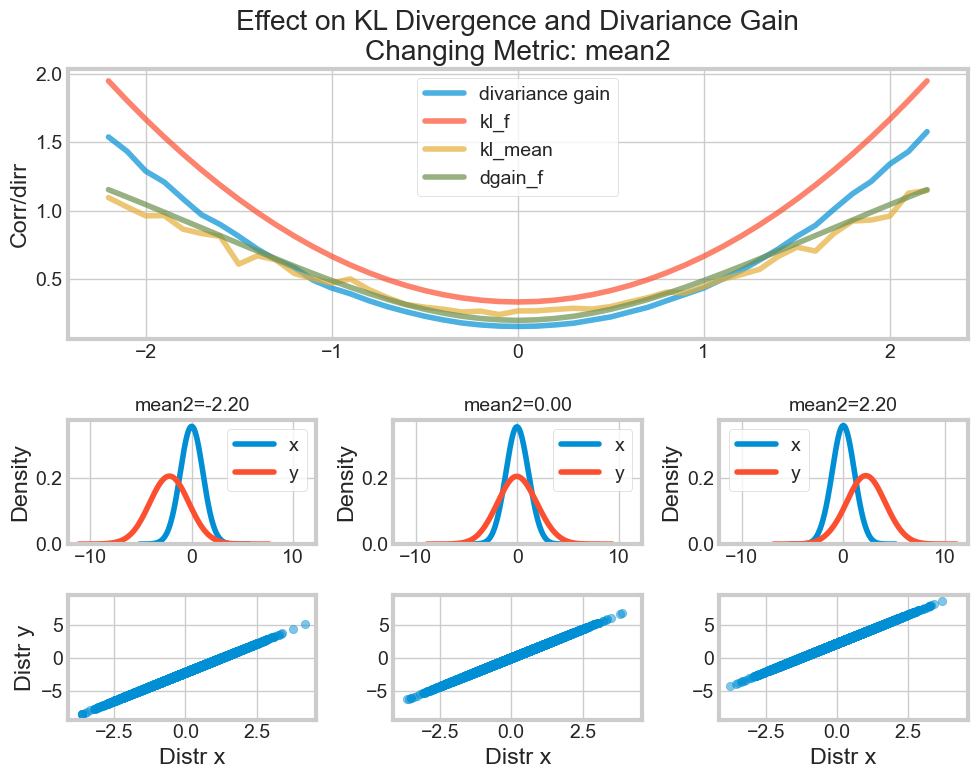

In [368]:
distr_default = {'mean1':0, 'mean2':0, 'var1':1, 'var2':3, 'corr':1, 'size':10000}

metric = 'mean2'
arange = np.arange(-2.2,2.3,0.1)
distr_corr=distr_default.copy()
distr_corr['corr']= 1

plot_keys = ['divariance gain','kl_f','kl_mean','dgain_f']
#plot_keys = ['kl_f','dgain_f']

plot_metric_subplots2(metric,arange,plot_keys,distr_corr,scale = 'base',title=f"{default_plot_title}{metric}")#,savefile='kl_mean.png')

Text(5, 0.1, 'Yj')

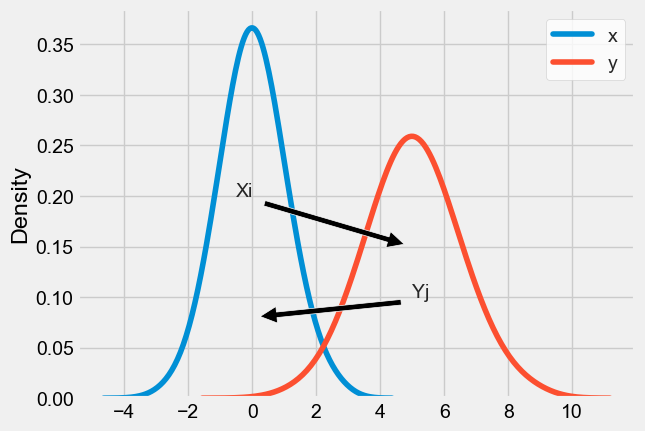

In [13]:
x, y = generate_distributions(mean1=0, mean2=5, var1=1, var2=2, corr=1, size=1000)
ax = plot_density(x,y,return_ax=True)
ax.annotate("Xi",xytext=(-0.5,0.20),xy=(5,0.15),arrowprops=dict(facecolor='black', shrink=0.05)) #,xycoords='data')
ax.annotate("Yj",xytext=(5,0.10),xy=(0,0.08),arrowprops=dict(facecolor='black', shrink=0.05)) #,xycoords='data');


In [180]:
np.round(np.cos(np.angle(complex(0,4),deg=False)),2)

np.float64(0.0)

In [229]:
def annotation_brackets(annotation='annotation', x_start = 2.5,x_end= 2.5,y_start = 0.1,y_end = 0.2,serif = 0.1,ann_offset=0.05,ax=None):
    # Define the y range and x position for the bracket
    x_length = abs(x_end - x_start)
    y_length = abs(y_end - y_start)
    # Length of serifs
    serif_pct = serif/np.sqrt(x_length**2+y_length**2)
    # Draw vertical bracket line
    ax.plot([x_start, x_end], [y_start, y_end], color='black', lw=2)
    
    # Top serif
    #ax.plot([x_bracket - serif, x_bracket + serif], [y_end, y_end], color='black', lw=2)
    # Bottom serif
    #ax.plot([x_bracket - serif, x_bracket + serif], [y_start, y_start], color='black', lw=2)

    # Top/left serif
    angle = np.angle(complex(x_length,y_length),deg=False)
    x_angle = np.round(np.sin(angle),2)
    y_angle = np.round(np.cos(angle),2)
    ax.plot([x_end - serif*x_angle, x_end + serif*x_angle], [y_end - serif*y_angle, y_end + serif*y_angle], color='black', lw=2)
    # Bottom serif
    ax.plot([x_start - serif*x_angle, x_start + serif*x_angle], [y_start - serif*y_angle, y_start + serif*y_angle], color='black', lw=2)

    
    # Add annotation text to the right
    ha = 'center'
    if x_angle*ann_offset<0:
        ha = 'right'
    elif x_angle*ann_offset>0:
        ha = 'left'
    ax.text((x_start+x_end)/2 + x_angle*(serif + ann_offset), (y_start + y_end) / 2 + y_angle*(serif + ann_offset), annotation, 
            va='center', ha=ha)
    return ax


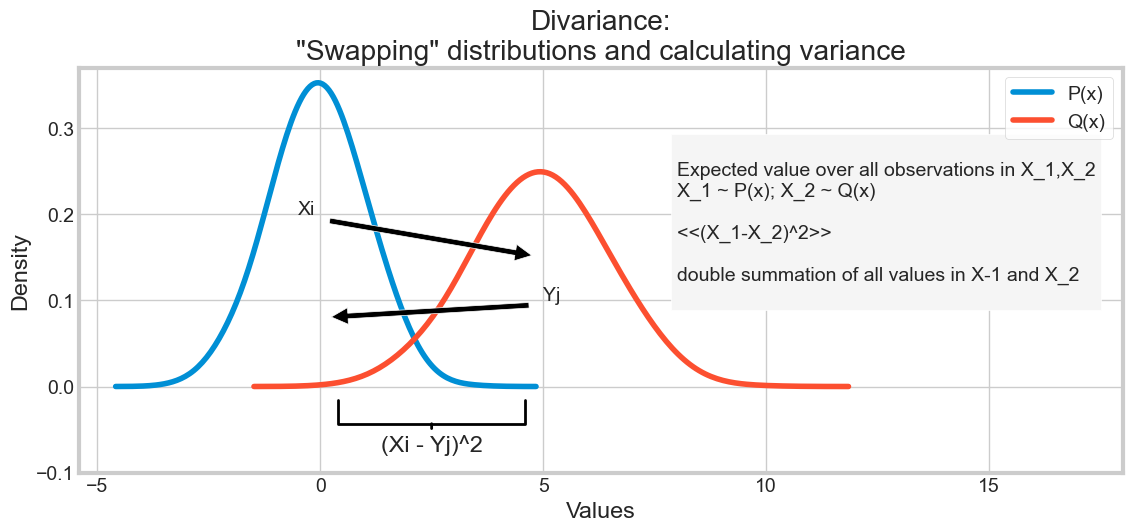

In [252]:
x, y = generate_distributions(mean1=0, mean2=5, var1=1, var2=2, corr=1, size=1000)
ax = plot_density(x,y,return_ax=True,figsize=(12, 5),xlabel='P(x)',ylabel='Q(x)')
ax.annotate("Xi",xytext=(-0.5,0.20),xy=(5,0.15),arrowprops=dict(facecolor='black', shrink=0.05)) #,xycoords='data')
ax.annotate("Yj",xytext=(5,0.10),xy=(0,0.08),arrowprops=dict(facecolor='black', shrink=0.05)) #,xycoords='data');
ax.set_xlabel('Values')
ax.set_ylim(bottom=-0.1)
ax.set_xlim(right=18)

ax.annotate("(Xi - Yj)^2", xy=(2.5, -0.04), xytext=(2.5, -0.08), xycoords='data', 
            fontsize=14*1.2, ha='center', va='bottom',
            #bbox=dict(boxstyle='square', fc='white', color='k'),
            arrowprops=dict(arrowstyle='-[, widthB=4, lengthB=1.0', lw=2.0, color='k'))

#ax = annotation_brackets(annotation='(Xi - Yj)^2', x_start = np.max(x)+1.8,x_end=np.max(y)+1.8,y_start = -0.035,y_end = -0.035,serif = serif,ann_offset=ann_offset,ax=ax);

ax.set_title('Divariance:\n"Swapping" distributions and calculating variance')
an_desc = \
"""
Expected value over all observations in X_1,X_2
X_1 ~ P(x); X_2 ~ Q(x)

<<(X_1-X_2)^2>> 

double summation of all values in X-1 and X_2
"""
ax.annotate(an_desc,xytext=(8,0.1),xy=(8,0.1),bbox=dict(boxstyle='square', fc='whitesmoke', color='w')); #,xycoords='data');
#axes fraction
#plt.savefig("divariance_explained.png",bbox_inches='tight')

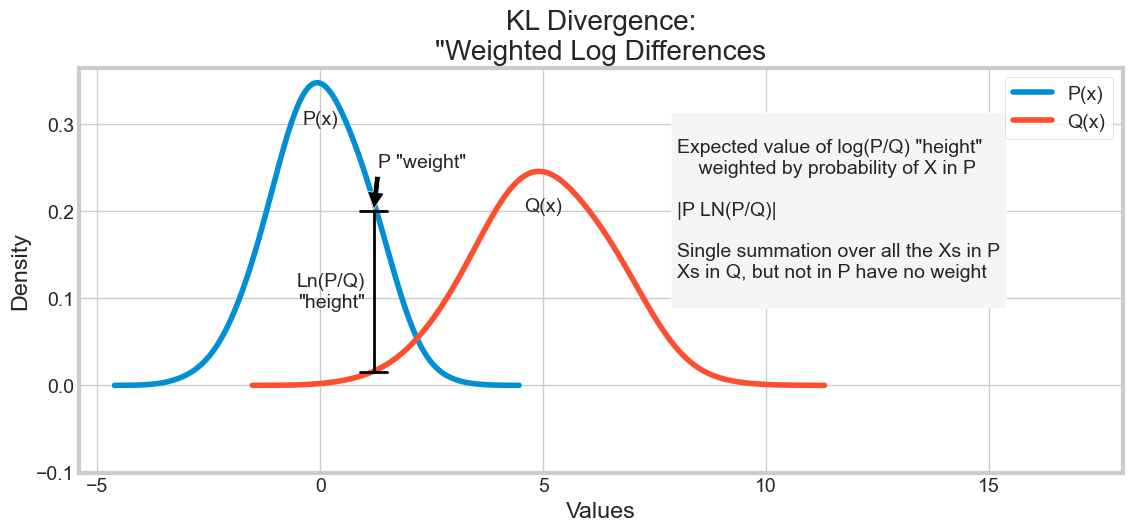

In [249]:
x, y = generate_distributions(mean1=0, mean2=5, var1=1, var2=2, corr=1, size=1000)
ax = plot_density(x,y,return_ax=True,figsize=(12, 5),xlabel='P(x)',ylabel='Q(x)')
#ax.annotate("Yj",xytext=(5,0.10),xy=(0,0.08),arrowprops=dict(facecolor='black', shrink=0.05)) #,xycoords='data');
ax.set_xlabel('Values')
ax.set_ylim(bottom=-0.1)
ax.set_xlim(right=18)


_ = """ax.annotate("Ln(P/Q)", xy=(2.0, 0.1), xytext=(2.0, 0.2), xycoords='data', 
            fontsize=14*1.2, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', color='k'),
            arrowprops=dict(arrowstyle=']-[, widthB=4, lengthB=1.0', lw=2.0, color='k'))
"""
ax.set_title('KL Divergence:\n"Weighted Log Differences')
an_desc = \
"""
Expected value of log(P/Q) "height" 
    weighted by probability of X in P

|P LN(P/Q)| 

Single summation over all the Xs in P
Xs in Q, but not in P have no weight
"""
ax.annotate(an_desc,xytext=(8,0.10),xy=(8,0.10),bbox=dict(boxstyle='square', fc='whitesmoke', color='w')); #,xycoords='data');
#axes fraction

ax = annotation_brackets(annotation='Ln(P/Q)\n"height"', x_start = 1.2, x_end=1.2,y_start = 0.015,y_end = 0.2,serif = 0.3,ann_offset=-0.5,ax=ax);
ax.annotate('P "weight"',xytext=(1.3,0.25),xy=(1.2,0.2),arrowprops=dict(facecolor='black', shrink=0.05),ha='left') #,xycoords='data')
ax.text(0,0.3,"P(x)",ha='center')
ax.text(5,0.2,"Q(x)",ha='center');
#plt.savefig("KLD_explained.png",bbox_inches='tight')

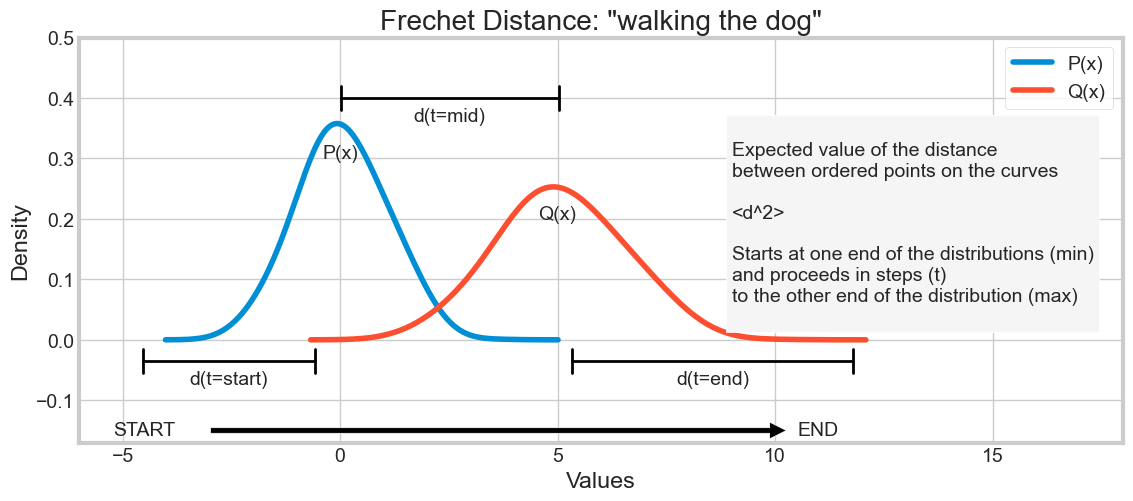

In [250]:
x, y = generate_distributions(mean1=0, mean2=5, var1=1, var2=2, corr=1, size=1000)
ax = plot_density(x,y,return_ax=True,figsize=(12, 5),xlabel='P(x)',ylabel='Q(x)')
#ax.annotate("Yj",xytext=(5,0.10),xy=(0,0.08),arrowprops=dict(facecolor='black', shrink=0.05)) #,xycoords='data');
ax.set_xlabel('Values')
ax.set_ylim(bottom=-0.17,top=0.5)
ax.set_xlim(right=18,left=-6)


_ = """ax.annotate("Ln(P/Q)", xy=(2.0, 0.1), xytext=(2.0, 0.2), xycoords='data', 
            fontsize=14*1.2, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', color='k'),
            arrowprops=dict(arrowstyle=']-[, widthB=4, lengthB=1.0', lw=2.0, color='k'))
"""
ax.set_title('Frechet Distance: "walking the dog"')
an_desc = \
"""
Expected value of the distance
between ordered points on the curves

<d^2>

Starts at one end of the distributions (min)
and proceeds in steps (t)
to the other end of the distribution (max)
"""
ax.annotate(an_desc,xytext=(9,0.03),xy=(9,0.03),bbox=dict(boxstyle='square', fc='whitesmoke', color='w')); #,xycoords='data');
#axes fraction
serif= 0.02
ann_offset=-0.05
ax = annotation_brackets(annotation='d(t=start)', x_start = np.min(x)-2,x_end=np.min(y)-2,y_start = -0.035,y_end = -0.035,serif = serif,ann_offset=ann_offset,ax=ax);
ax = annotation_brackets(annotation='d(t=mid)', x_start = np.median(x),x_end=np.median(y),y_start = 0.4,y_end = 0.4,serif = serif,ann_offset=ann_offset,ax=ax);
ax = annotation_brackets(annotation='d(t=end)', x_start = np.max(x)+1.8,x_end=np.max(y)+1.8,y_start = -0.035,y_end = -0.035,serif = serif,ann_offset=ann_offset,ax=ax);

ax.annotate('START',xytext=(-4.5,-0.15),xy=(11,-0.15),arrowprops=dict(facecolor='black', shrink=0.05),ha='center',va='center') #,xycoords='data')
ax.text(0,0.3,"P(x)",ha='center')
ax.text(5,0.2,"Q(x)",ha='center');
#ax.text(-5,0.43,"START",ha='center');
ax.text(11,-0.15,"END",ha='center',va='center');
#plt.savefig("frechet_explained.png",bbox_inches='tight')

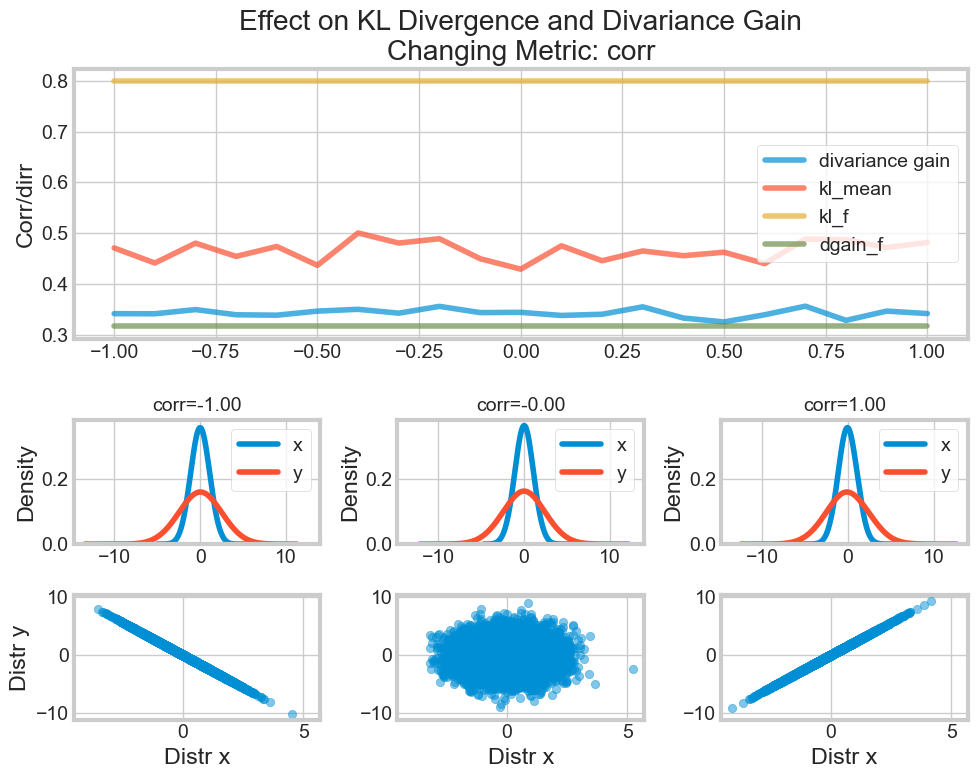

In [229]:
metric = 'corr'
arange = np.arange(-1,1.1,0.1)
plot_keys = ['divariance gain','kl_mean','kl_f','dgain_f']
plot_metric_subplots2(metric,arange,plot_keys,distr_default,scale = 'base',title=f"{default_plot_title}{metric}")#,savefile='kl_corr.png',support_plots=False)

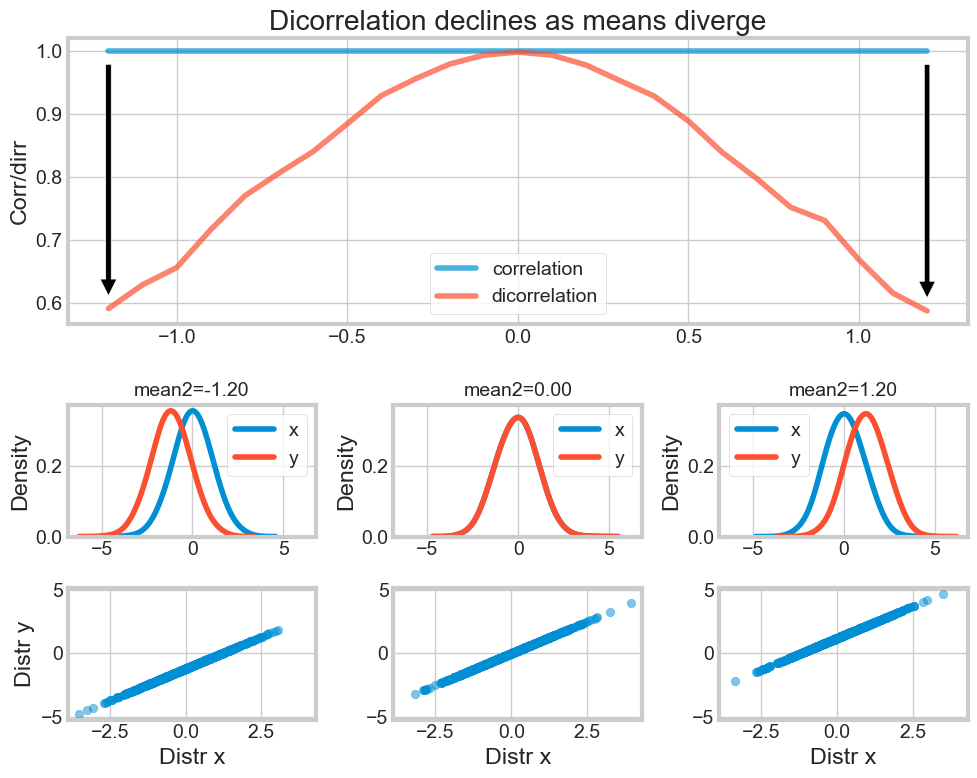

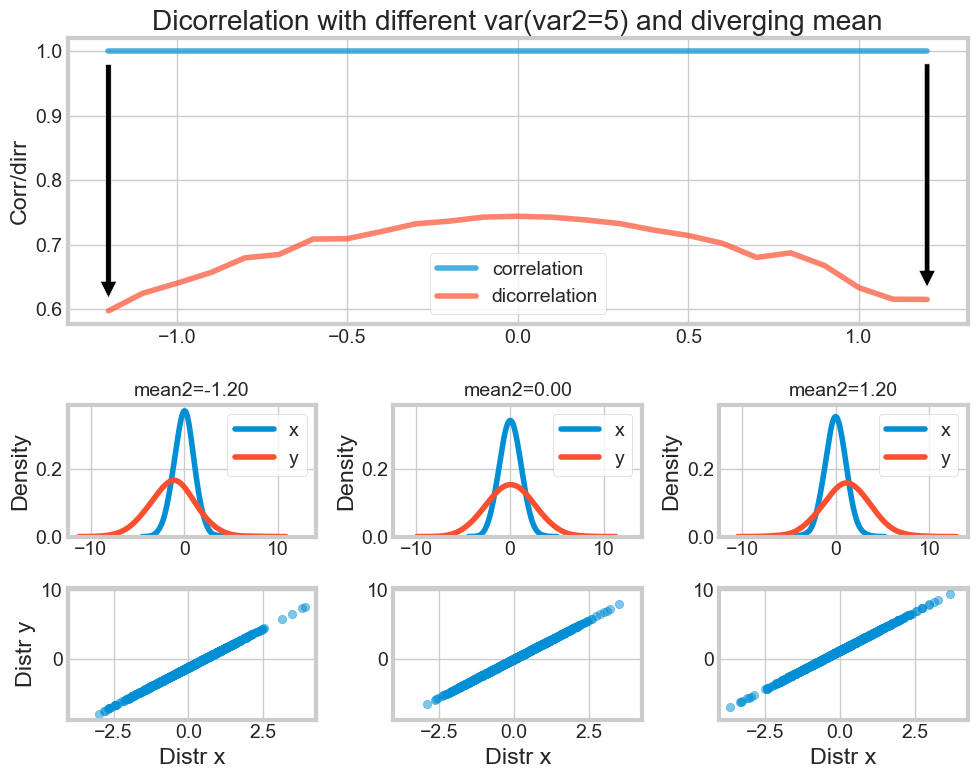

In [78]:
metric = 'mean2'
arange = np.arange(-1.2,1.3,0.1)
distr_corr=distr_default.copy()
#distr_corr['var2']= 5

plot_keys = ['correlation','dicorrelation']
plot_metric_subplots2(metric,arange,plot_keys,distr_corr,scale = 'base',title=f"Dicorrelation declines as means diverge",savefile='corr_mean.png')

distr_corr=distr_default.copy()
distr_corr['var2']= 5
plot_metric_subplots2(metric,arange,plot_keys,distr_corr,scale = 'base',title=f"Dicorrelation with different var(var2=5) and diverging mean",savefile='corr_mean_var5.png')


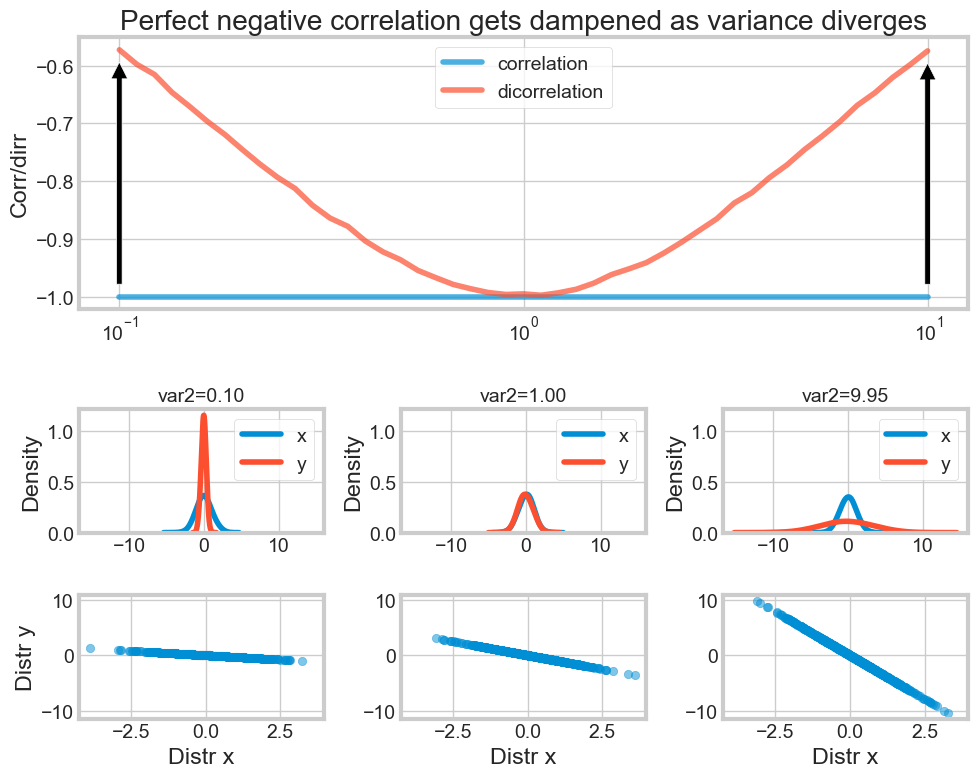

In [73]:
metric = 'var2'
arange = np.exp(np.arange(np.log(0.1),np.log(10.1),0.1)) #log based range for equal iterations on each side of 1, good for variance, which is symmetrical by ratio
distr_corr=distr_default.copy()
#distr_corr['mean2']= 1
distr_corr['corr']= -1

plot_keys = ['correlation','dicorrelation']
plot_metric_subplots2(metric,arange,plot_keys,distr_corr,scale = 'log',title=f"Perfect negative correlation gets dampened as variance diverges",savefile='corr_var.png')

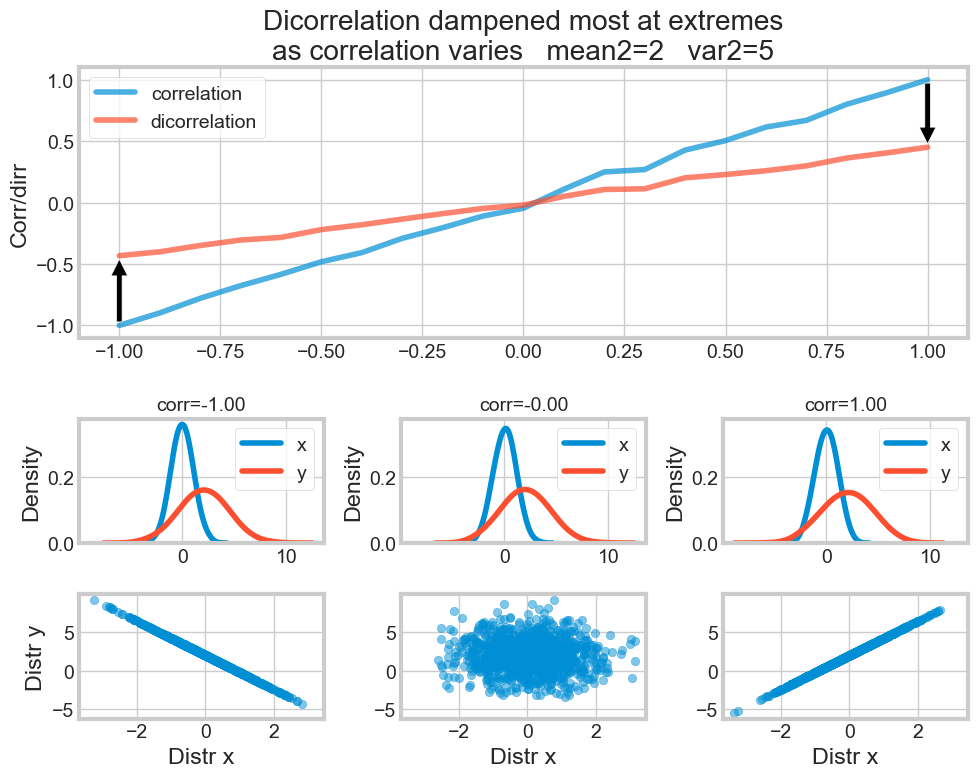

In [75]:
metric = 'corr'
arange = np.arange(-1,1.1,0.1)
distr_corr=distr_default.copy()
distr_corr['var2']= 5

distr_corr['mean2']= 2

plot_keys = ['correlation','dicorrelation']
plot_metric_subplots2(metric,arange,plot_keys,distr_corr,scale = 'base',title=f"Dicorrelation dampened most at extremes\nas correlation varies   mean2=2   var2=5",savefile='corr_corr.png')


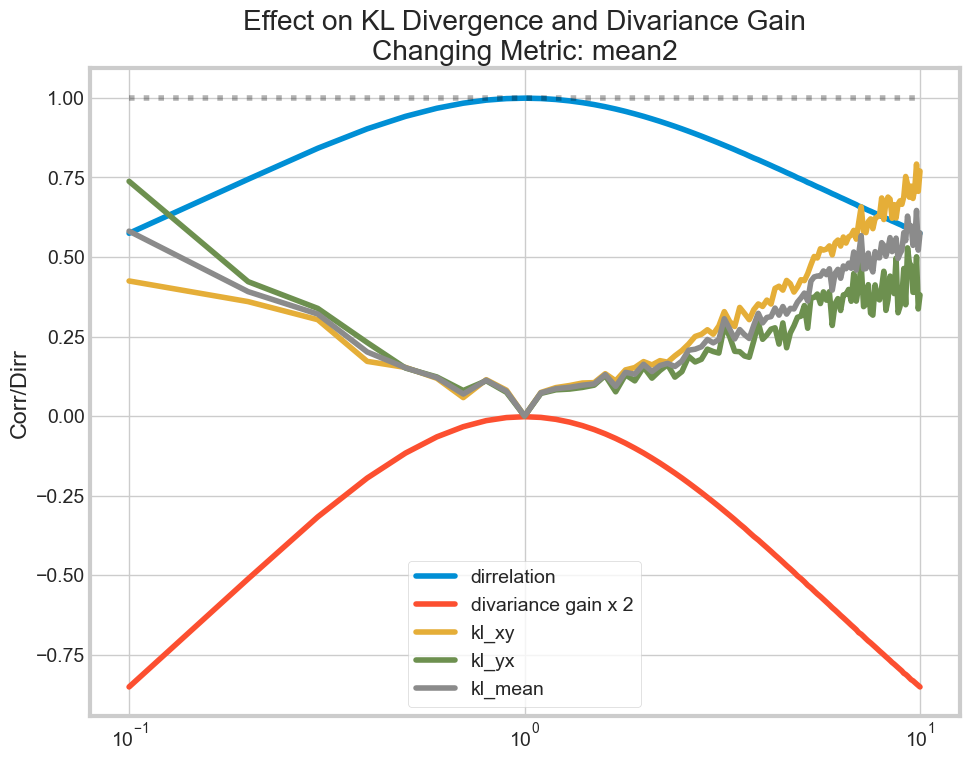

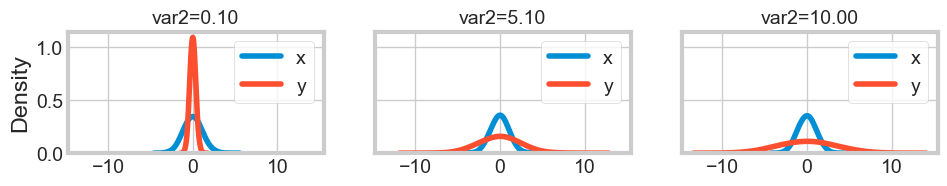

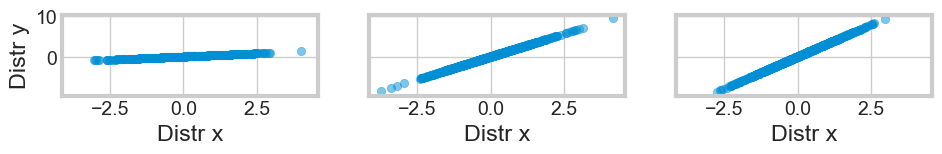

In [76]:
metric = 'var2'
arange = np.arange(0.1,10.1,0.1)
plot_metric_subplots(metric,arange,distr_default,scale = 'log')

## var change analysis
it looks like dirrelation follows relatively closely with KL divergence... especially if you plot it starting at 0 (divariance gain is how I've referred to it)
it might be better to plot on a log scale - its more symmetrical and easier to tell the story.  divariance gain is smoother - less prone to vagaries of samples.  Its also interpretable in terms of variance... the percent increase in variance by swapping labels.  You also can calculate it on arrays directly, vs converting to distributions.

its a smooth closed form calculation, rather than an algorithmic estimation.  Interesting that if you double divariance gain, you essentially get the average of the kl-divergence... kind ofthe shapes are a little different.  

The net of this analysis has less to do with covariance than to do with KL divergence.  thats ok.  It essentially addresses my point... although looking at changing correlation AND var/mean seems interesting... I may or may not address that...

I also could combine correlation and dirrelation to get a join metric (corr/

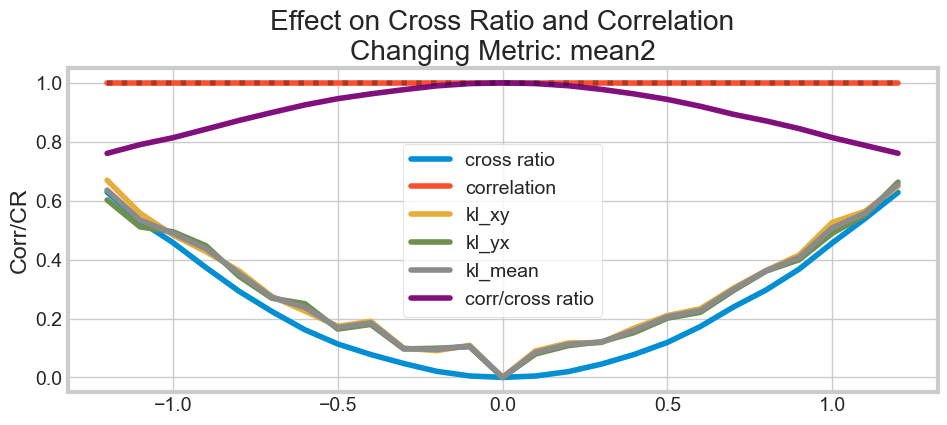

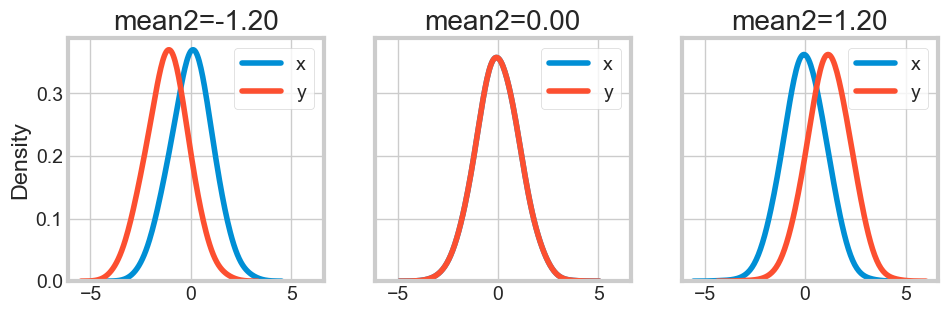

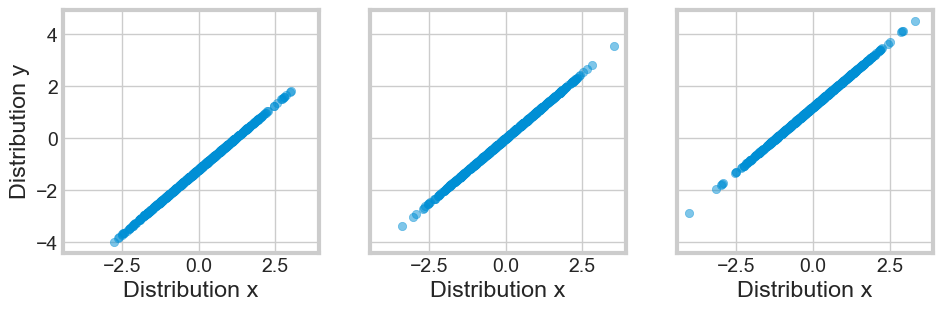

In [369]:
metric = 'mean2'
arange = np.arange(-1.2,1.3,0.1)
plot_metric_subplots(metric,arange,distr_default)

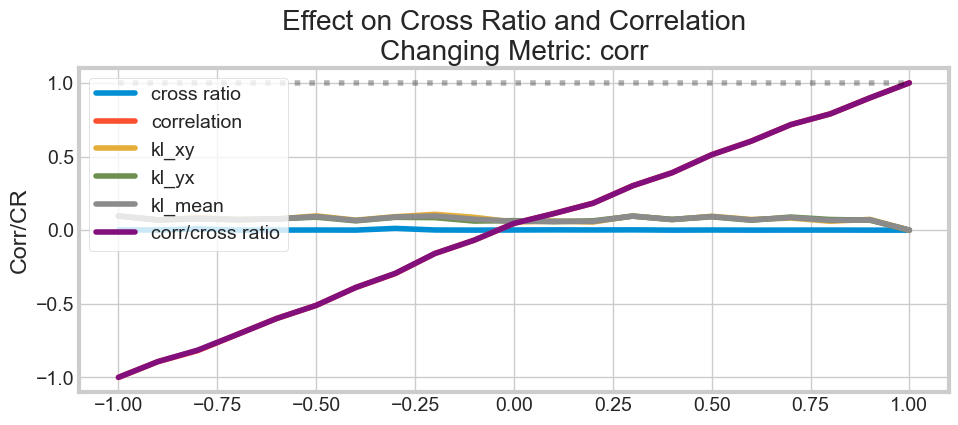

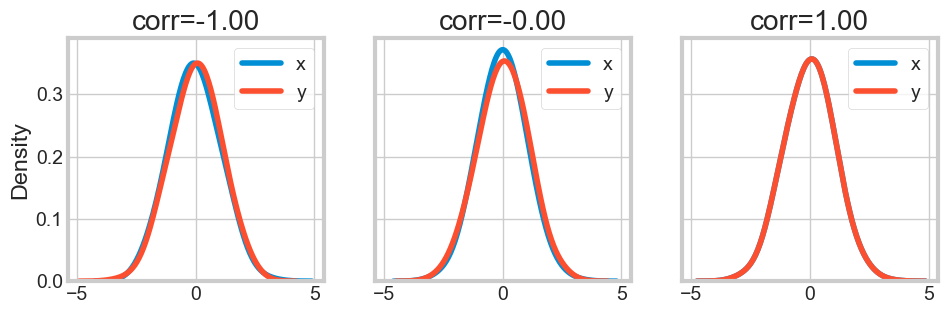

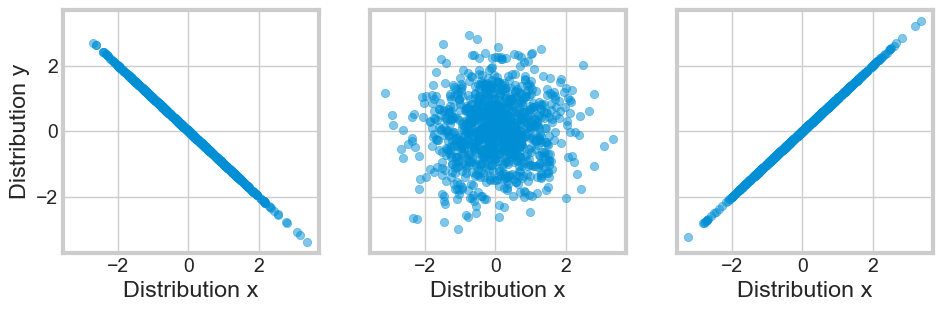

In [370]:
metric = 'corr'
arange = np.arange(-1,1.1,0.1)
plot_metric_subplots(metric,arange,distr_default)

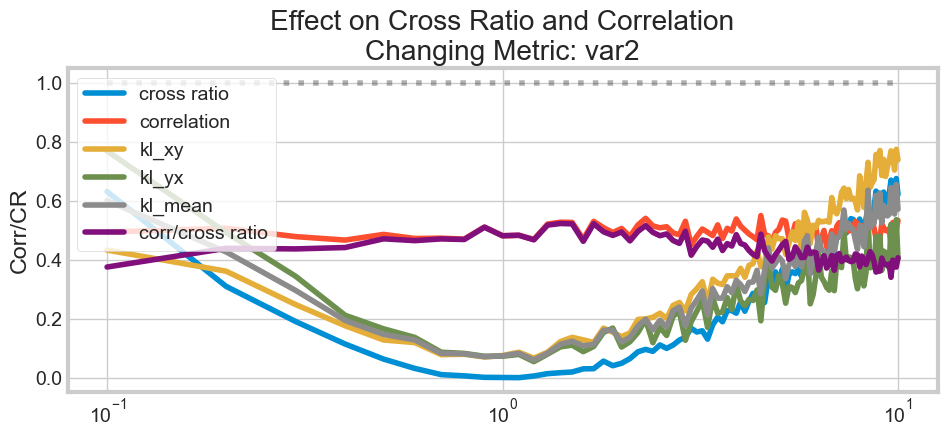

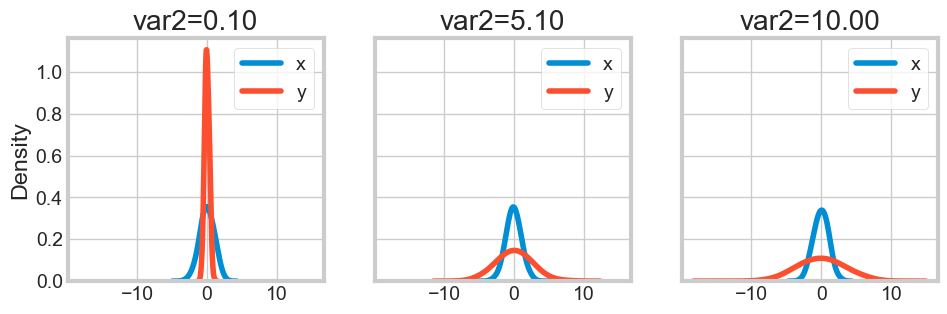

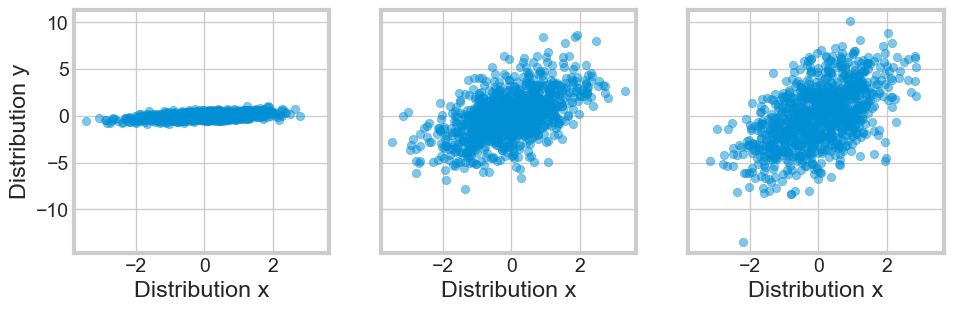

In [371]:
metric = 'var2'
arange = np.arange(0.1,10.1,0.1)
distr_corr=distr_default.copy()
distr_corr['corr']=0.5
plot_metric_subplots(metric,arange,distr_corr,scale = 'log')

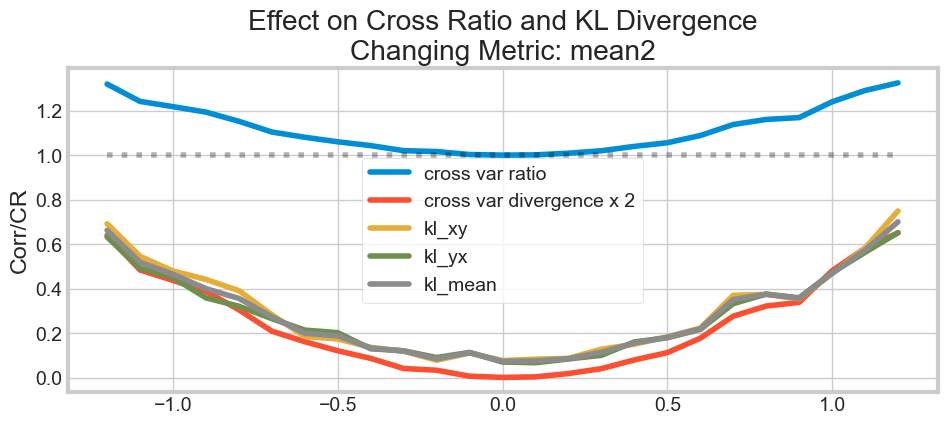

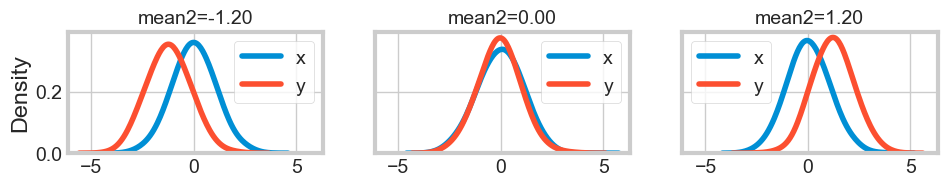

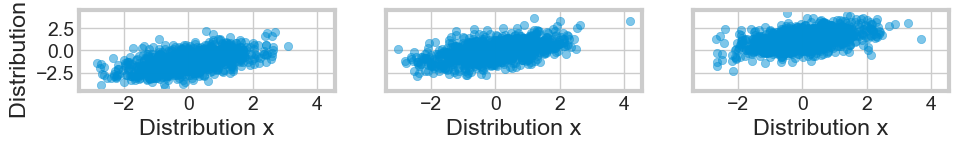

In [413]:
metric = 'mean2'
arange = np.arange(-1.2,1.3,0.1)
distr_corr=distr_default.copy()
distr_corr['corr']=0.5
plot_metric_subplots(metric,arange,distr_corr,scale = 'base',title=f"{defulat_plot_title}{metric}")

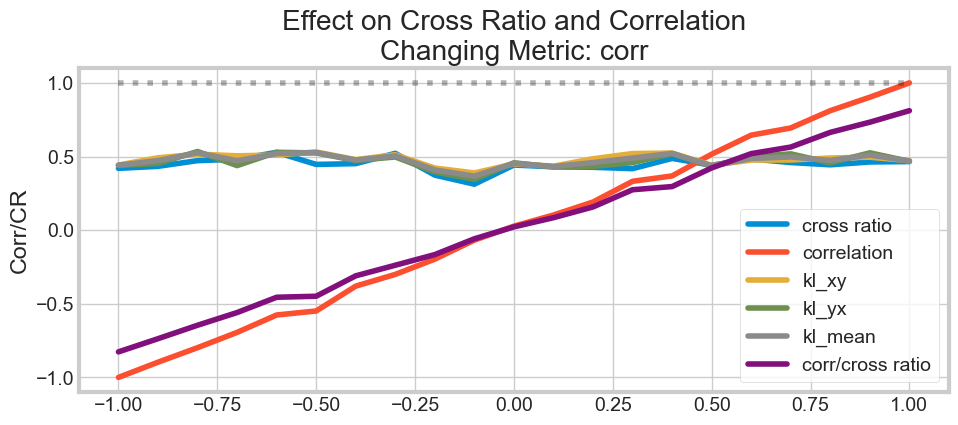

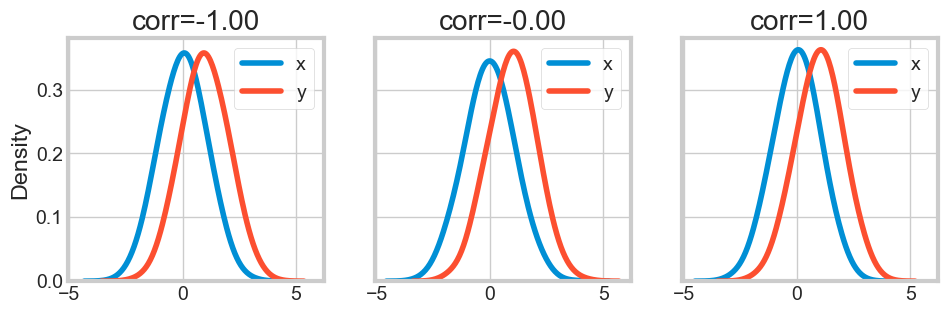

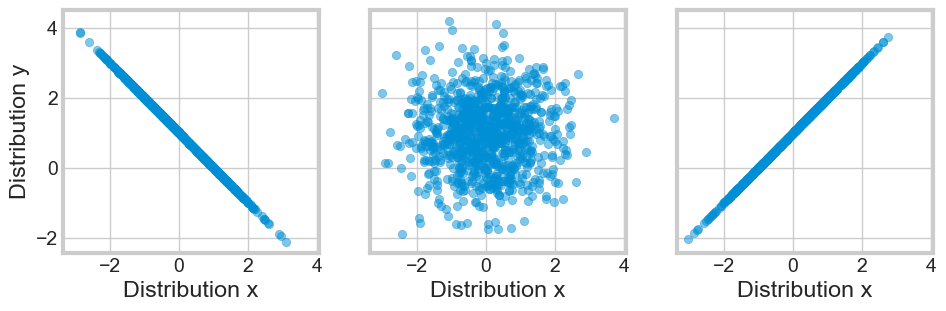

In [374]:
metric = 'corr'
arange = np.arange(-1,1.1,0.1)
distr_mean=distr_default.copy()
distr_mean['mean2']=1

plot_metric_subplots(metric,arange,distr_mean)

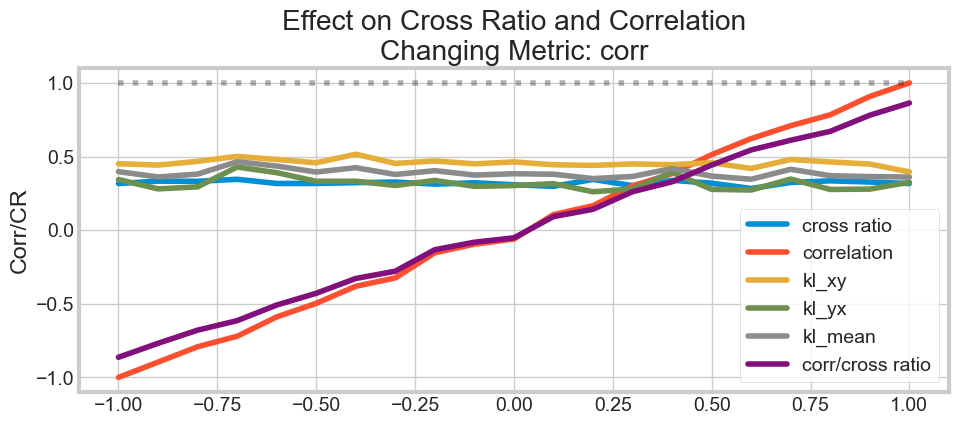

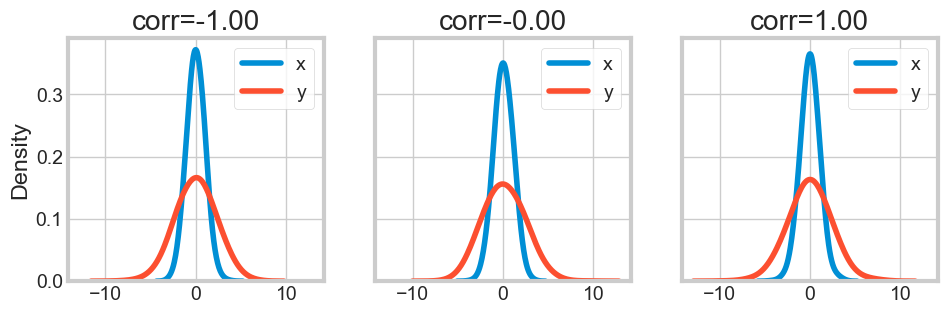

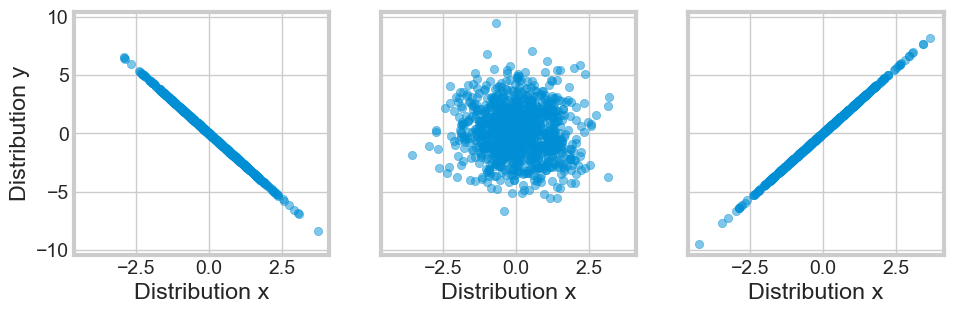

In [376]:
metric = 'corr'
arange = np.arange(-1,1.1,0.1)
distr_var=distr_default.copy()
distr_var['var2']=5

plot_metric_subplots(metric,arange,distr_var)

## Extra code

In [ ]:
fig = plt.figure(figsize=(10,6))
#fig, axes = plt.subplots(3,3,figsize=[10,8],sharex='row',sharey='row')
gs = fig.add_gridspec(3,2,height_ratios=[2,1,1])
ax0=fig.add_subplot(gs[0,:])
ax1=fig.add_subplot(gs[1,0])
ax2=fig.add_subplot(gs[1,1],sharex=ax1)
ax3=fig.add_subplot(gs[2,0])
ax4=fig.add_subplot(gs[2,1])

In [123]:
a, b = 3,1
np.exp(a) - np.exp(b)

np.float64(17.367255094728623)

In [109]:
np.exp(1/a)

np.float64(1.3956124250860895)

In [110]:
np.exp(1/b)

np.float64(2.718281828459045)

In [111]:
np.exp(1/b)*np.exp(1/a)

np.float64(3.7936678946831774)

In [126]:
(np.exp(a/100)-np.exp(b/100))

np.float64(0.02040436686934899)

In [127]:
(np.exp(a) - np.exp(b))/np.exp(10)

np.float64(0.0007884721614678366)

In [131]:
(np.exp(a-100) - np.exp(b-100))*np.exp(100)

np.float64(17.367255094728627)

In [132]:
np.exp(a-100)

np.float64(7.47197233734299e-43)

In [568]:
from sklearn.feature_selection import mutual_info_regression
import numpy as np

# Generate sample data
np.random.seed(0)
X = np.random.rand(100, 2)
y = X[:, 0] + np.sin(6 * np.pi * X[:, 1])

# Calculate Mutual Information using mutual_info_regression
mutual_info = mutual_info_regression(X, y)
print("Mutual Information for each feature:", mutual_info)

Mutual Information for each feature: [0.42283584 0.54090791]
